## prompt
以下の手順で`data_persons.csv`を作成してください。
1. `data_persons.csv`の1行目を以下にする。
`person_id,household_id,person_role_in_household,誕生年月日,収入,性別`
2. persons.json を読み込み、`persons_list`とする。
3. `persons_list`を順に以下処理を行う。`household_id`が`null`の場合はスキップ
4. 一意な`person_id`を付与する。
5. `person_role_in_household`について、`age`が18以上の場合は"親", 18未満の場合は"子"とする
6. `誕生年月日`は"YYYY-01-01"とし、"YYYY"は{2025 - age}で計算した値とする。
7. `収入`は`income * 10000`で計算された値とする。
8. `性別`は`sex`が"male"の場合は"男性", "female"の場合は"女性"とする。
9. 設定した値を`data_persons.csv`に追加する。



In [22]:
import os
import json, csv, sys
from pathlib import Path
from datetime import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from openfisca_core.simulation_builder import SimulationBuilder
from openfisca_japan import CountryTaxBenefitSystem

# 日本語フォントの設定（macOS用）
plt.rcParams['font.family'] = 'Hiragino Sans'

In [23]:
# 生成個人データからOpenFisca用のperson csvを作成する
def create_data_persons_csv(json_path, csv_path):
    # 読み込み
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # persons_list の決定（配列/辞書どちらにも対応）
    persons_list = []
    if isinstance(data, list):
        persons_list = data
    elif isinstance(data, dict):
        if isinstance(data.get('persons'), list):
            persons_list = data['persons']
        else:
            values = list(data.values())
            if values and all(isinstance(v, dict) for v in values):
                persons_list = values
            else:
                persons_list = []

    # CSV 書き込み
    header = ['person_id','household_id','person_role_in_household',
                '誕生年月日','収入','性別']
    with open(csv_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        person_id_seq = 1
        for p in persons_list:
            if not isinstance(p, dict):
                continue
            household_id = p.get('household_id')
            if household_id is None:
                continue
            # age
            age = p.get('age')
            try:
                age_int = int(age) if age is not None else None
            except Exception:
                age_int = None
            # role
            if age_int is None:
                role = ''
            else:
                role = '親' if age_int >= 18 else '子'  # 子どもがいなくても18歳以上は`親`role
            # 誕生年月日
            if age_int is None:
                dob = ''
            else:
                year = 2025 - age_int
                dob = f"{year:04d}-01-01"
            # 収入
            income = p.get('income')
            try:
                income_val = float(income) if income is not None else 0.0
            except Exception:
                income_val = 0.0
            income_out = int(round(income_val * 10000))
            # 性別
            sex = (p.get('sex') or '').lower()
            if sex == 'male':
                gender = '男性'
            elif sex == 'female':
                gender = '女性'
            else:
                gender = ''
            # 行追加
            writer.writerow([person_id_seq, household_id, role, dob, income_out, gender])
            person_id_seq += 1

    print(str(csv_path))

## prompt
以下の手順で`data_households.csv`を作成するコードをnotebookに記載してください。
1. `data_households.csv`の1行目を以下にする。
`household_id,居住都道府県,居住市区町村`
2. persons.json を読み込み、`persons_list`とする。
3. `persons_list`の`household_id`の最小値と最大値を取得する。
4. 最小値から最大値までの`household_id`を`data_households.csv`に追加する。`居住都道府県`は"神奈川県", `居住市区町村`は"横浜市"とする。
5. 設定した値を`data_persons.csv`に追加する。



In [24]:
# 生成個人データからOpenFisca用のhousehold csvを作成する
# data_households.csv を生成する
def create_data_households_csv(json_path, csv_path):
    # persons.json 読み込み
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # persons_list の抽出（配列/辞書に対応）
    if isinstance(data, list):
        persons_list = data
    elif isinstance(data, dict):
        if isinstance(data.get('persons'), list):
            persons_list = data['persons']
        else:
            vals = list(data.values())
            if vals and all(isinstance(v, dict) for v in vals):
                persons_list = vals
            else:
                persons_list = []
    else:
        persons_list = []

    # household_id 値の収集（null/None を除外）
    household_ids = []
    for p in persons_list:
        if not isinstance(p, dict):
            continue
        hid = p.get('household_id')
        if hid is None:
            continue
        try:
            household_ids.append(int(hid))
        except Exception:
            continue

    if household_ids:
        hh_min, hh_max = min(household_ids), max(household_ids)
    else:
        hh_min = hh_max = None

    # CSV 書き込み
    header = ['household_id', '居住都道府県', '居住市区町村']
    with open(csv_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        if hh_min is not None and hh_max is not None:
            for hid in range(hh_min, hh_max + 1):
                writer.writerow([hid, '神奈川県', '横浜市'])

    print(f'Wrote: {csv_path}')


In [25]:
def calc_openfisca(data_persons_dict, data_households_dict, 
                    person_var_list, household_var_list,
                    output_var_list,
                    period="2025-11-01"):
    """
    OpenFiscaの準備
    input: 
        data_persons_dict: 人物データ. 
            ex. {"person_id": np.array([...]), "household_id": np.array([...]),
                "person_role_in_household": np.array([...]),
                個人属性: np.array([...]) , ...}
        data_households_dict: 世帯データ. ex. {"household_id": np.array([...]), 世帯属性: np.array([...]) , ...}
        person_var_list: 計算に用いる個人属性リスト. ex. ["誕生年月日", "性別", "収入"]
        household_var_list: 計算に用いる世帯属性リスト. ex. ["居住都道府県", "居住市区町村"]
        output_var_list: 出力属性リスト. ex. ["生活保護", "児童手当", "児童扶養手当_最小"]
            世帯属性, 個人属性が混在していても良い
        period: 計算対象の日時. YYYY-MM-DD 形式で記述する. 過去の日時も指定可能

    output:
        output_dict: 出力属性リストの値. ex. {"生活保護": np.array([...]), "児童手当": np.array([...]), "児童扶養手当_最小": np.array([...]) , ...}
            それぞれの属性の出力長は個人・世帯の数に準じる
    """
    ### OpenFiscaの準備 ###
    tax_benefit_system = CountryTaxBenefitSystem()
    sb = SimulationBuilder()
    sb.create_entities(tax_benefit_system)

    # 人物(世帯員)と世帯のそれぞれ一意なIDの登録
    sb.declare_person_entity("人物", data_persons_dict["person_id"])
    household_instance = sb.declare_entity("世帯", data_households_dict["household_id"])

    # 人物(世帯員)と世帯の紐付け #
    person_household = data_persons_dict["household_id"]
    # 人物(世帯員, entity)のrole. ["親", "子", "祖父母"] のいずれか
    person_household_role = data_persons_dict["person_role_in_household"]
    sb.join_with_persons(household_instance, person_household, person_household_role)


    ### 必須の入力属性 ###
    # (その他の必須ではない属性は未入力の場合デフォルト値が適用されるため、基本的な制度の計算には影響なし.
    # ex. 身体障害者手帳: 無)
    simulation = sb.build(tax_benefit_system)

    for var in person_var_list:
        simulation.set_input(var, period, data_persons_dict[var])
    for var in household_var_list:
        simulation.set_input(var, period, data_households_dict[var])
    
    output_dict = {}
    for var in output_var_list:
        amount = simulation.calculate(var, period)
        # ndarrayの場合はリストに変換
        if isinstance(amount, np.ndarray):
            amount = amount.tolist()
        output_dict[var] = amount

    return output_dict

# OpenFisca-Japanで最低生活費算出のための生活保護と児童関連手当を計算しjsonを生成する

In [26]:
# (収入非依存にするため収入を0円とする)
def calc_seiho_allowance(data_persons_path, 
                        data_households_path,
                        zero_income=False):
    ## データの読み込み ###
    # 人物単位で定義される属性(ex. 誕生年月日)と世帯単位で定義される属性(ex. 居住都道府県)を区別して読み込む
    # 人物ID, 世帯IDとそれぞれ紐づくため

    # 人物データ. 
    data_persons = np.loadtxt(data_persons_path, delimiter=",", dtype=str,
                                encoding="utf-8")
    # data_persons_dict = {列名: 列の配列} のフォーマットにする
    data_persons_dict = {}
    for i in range(len(data_persons[0])):
        data_persons_dict[data_persons[0, i]] = data_persons[1:, i]

    if zero_income:  # BI算出用
        # 収入に依存しない最低生活費を算出するため収入は0円とする
        data_persons_dict["収入"] = np.zeros(len(data_persons_dict["収入"]), dtype=float)
    data_persons_dict["収入"] = data_persons_dict["収入"].astype(float)

    # 世帯データ
    data_households = np.loadtxt(data_households_path, delimiter=",", dtype=str,
                                    encoding="utf-8")
    # data_households_dict = {列名: 列の配列} のフォーマットにする
    data_households_dict = {}
    for i in range(len(data_households[0])):
        data_households_dict[data_households[0, i]] = data_households[1:, i]

    person_var_list = ["誕生年月日", "性別", "収入"]
    household_var_list = ["居住都道府県", "居住市区町村"]
    # "控除後所得"のみ個人属性(従来制度額算出用)
    allowance_list = ["生活保護", "児童手当", "児童扶養手当_最小", "控除後所得"]

    output_dict = calc_openfisca(data_persons_dict, data_households_dict, 
                    person_var_list, household_var_list,
                    allowance_list,
                    period="2025-11-01")  # 12月は期末一時扶助が入るためそれ以外

    # NOTE: 生活保護 = np.clip(最低生活費 - 月収 - 各種手当額, 0.0, None) で計算されるため
    # 最低生活費 = 生活保護 (+ 月収; 0) + 各種手当額 とすると、
    # OpenFiscaの最低生活費が各種手当額より小さい場合は0にclipされ、
    # 結果的に最低生活費は各種手当額になる。（児童関連の手当なので含めて良い）

    # 例: data_persons_dict = {"person_id": np.array([...]), "household_id": np.array([...]), ...}
    # df = pd.DataFrame({k: np.asarray(v) for k, v in output_dict.items()})
    # df.to_csv(data_households_allowance_path, index=False, encoding="utf-8")

    return output_dict


# 生活保護と児童関連手当をもとに個人の最低生活保障を算出する

In [27]:
# persons_BI.json を生成する
def calc_BI(data_persons_path, 
            seiho_allowance_dict):
    persons_csv = data_persons_path

    # 最低生活保障 = 生活保護 + 児童手当 + 児童扶養手当_最小
    add_var_list = ['生活保護', '児童手当', '児童扶養手当_最小']  # 児童育成手当は東京都のみのため除外

    # personsの読み込み
    with persons_csv.open('r', encoding='utf-8') as f:
        persons_reader = csv.DictReader(f)
        persons_rows = list(persons_reader)

    # household_idごとに1回だけ最低生活保障を算入
    seen_households = set()

    # 出力: person_id -> dict で出力（指示1に合わせる）
    persons_bi = {}
    for row in persons_rows:
        person_id = str(row.get('person_id'))
        if not person_id or person_id == 'None':
            continue

        household_id = str(row.get('household_id')) if row.get('household_id') is not None else ''

        entry = {
            'household_id': household_id,
            'person_role_in_household': row.get('person_role_in_household', ''),
            '誕生年月日': row.get('誕生年月日', ''),
            '性別': row.get('性別', ''),
            '収入': row.get('収入', ''),
            # 個人IDは1から始まるため-1
            '控除後所得': seiho_allowance_dict['控除後所得'][int(person_id)-1],
        }

        # 最低生活保障の計算
        bi = 0
        if household_id:
            if household_id not in seen_households:
                for add_var in add_var_list:
                    # 世帯IDは1から始まるため-1
                    bi += seiho_allowance_dict[add_var][int(household_id)-1]
                seen_households.add(household_id)
            else:
                bi = 0
        entry['最低生活保障'] = bi * 12  # 年額に変換

        persons_bi[person_id] = entry

    return persons_bi


In [28]:
# 親の収入を計算し、児童含む個人属性として付与(児童の所得算出用)
def calc_parent_income(persons_bi_dict):
    # household_id ごとの親の収入リストを構築
    household_to_parent_incomes = {}

    def to_number(x):
        try:
            return float(x)
        except Exception:
            return 0.0

    for person_id, info in persons_bi_dict.items():
        role = info.get('person_role_in_household')
        hid = str(info.get('household_id') or '')
        if not hid:
            continue
        if role == '親':
            income_val = to_number(info.get('収入', 0))
            household_to_parent_incomes.setdefault(hid, []).append(income_val)

    # persons_bi_dict に収入_親を追加
    for person_id, person in persons_bi_dict.items():
        role = person.get('person_role_in_household')
        hid = str(person.get('household_id') or '')

        # 収入_親の算出
        if role == '親':  # 親の場合はそのまま自分の収入
            parent_income = to_number(person.get('収入', 0))
        else:  # 子(18歳未満)
            parent_incomes = household_to_parent_incomes.get(hid, [])
            if parent_incomes:
                parent_income = sum(parent_incomes) / len(parent_incomes)
            else:
                parent_income = 0.0

        person['収入_親'] = parent_income

    return persons_bi_dict

In [29]:
# 年齢計算用のヘルパー関数
def calc_age(birth_date_str):
    """誕生年月日から年齢を計算（YYYY-01-01形式）"""
    if not birth_date_str:
        return None
    try:
        year = int(birth_date_str[:4])
        return 2025 - year
    except Exception:
        return None

# 世帯タイプの事前計算
def calc_household_type(persons_dict):
    # 世帯ごとのpersonをグループ化
    household_to_persons = defaultdict(list)
    for person_id, person in persons_dict.items():
        household_id = str(person.get('household_id', ''))
        if household_id:
            household_to_persons[household_id].append((person_id, person))

    # 各personのsurplusを計算
    surplus_total = 0.0
    for person_id, person in persons_dict.items():
        # 収入_親と年齢を取得
        parent_income = float(person.get('収入_親', 0))
        age = person.get('年齢')  # 自分の年齢
        if age is None:
            birth_date = person.get('誕生年月日', '')
            age = calc_age(birth_date)

        assert age is not None, f"age is None: {person}"
        
        household_id = str(person.get('household_id', ''))
        if not household_id:
            continue
        
        # 同じ世帯のpersonを収集
        household_persons = household_to_persons.get(household_id, [])
        
        # 世帯タイプ分類
        if age < 18:  # 自分が児童. 児童のみの単身世帯はない
            household_type = "child"
        elif age < 65:  # 現役世代
            if len(household_persons) == 1:  # 単身世帯  
                household_type = "single_young"
            else:
                household_type = "couple_young"
        else:  # 高齢世代
            if len(household_persons) == 1:
                household_type = "single_elder"
            else:
                household_type = "couple_elder"

        person["世帯タイプ"] = household_type

    return persons_dict


In [30]:
# OpenFisca用の個人・世帯データから、BI等必要な情報を算出
def calc_all_preprocess(data_persons_path, data_households_path):
    # OpenFiscaで手当(生活保護と児童関連手当)を算出
    seiho_allowance_dict = calc_seiho_allowance(data_persons_path, 
                                                data_households_path,
                                                zero_income=True)  # BI算出用

    # 手当をもとに最低生活保障を算出
    persons_dict = calc_BI(data_persons_path, seiho_allowance_dict)

    # 親の収入を計算する(子どもの所得算出用)        
    persons_dict = calc_parent_income(persons_dict)

    # 世帯タイプの事前計算
    persons_dict = calc_household_type(persons_dict)

    return persons_dict

# OpenFisca用の個人・世帯データから、従来制度の手当, 所得税引き後金額を算出
def calc_all_preprocess_actual(data_persons_path, data_households_path):
    # OpenFiscaで手当(生活保護と児童関連手当)を算出
    seiho_allowance_dict = calc_seiho_allowance(data_persons_path, 
                                                data_households_path,
                                                zero_income=False)  # 収入はそのまま
    # dictをインデントありで出力
    #print("seiho_allowance_dict")
    #print(json.dumps(seiho_allowance_dict, ensure_ascii=False, indent=2))
    # 手当をもとに最低生活保障を算出
    persons_dict = calc_BI(data_persons_path, seiho_allowance_dict)

    return persons_dict

## prompt 実際の所得税引き後金額を計算
以下の手順で実際の所得税引き後金額(`income_actual_total`)を計算する。
1. data_persons_income_deduction.csv を読み込み
2. personごとに以下を計算する。
   `income_tax_list` をもとに、`控除後所得`が`income_range`の範囲内にあるdictを参照し、`tax_rate`, `deduction`を取得する
   ```
   income_tax = 控除後所得 * tax_rate - deduction
   income_actual = 収入 - income_tax
   ```
3. 全personの`income_actual`を合計する

In [31]:
# 所得税を計算する関数
def calc_income_tax(deducted_income, income_tax_list):
    """控除後所得から所得税を計算"""
    for tax_info in income_tax_list:
        min_income, max_income = tax_info['income_range']
        if min_income <= deducted_income <= max_income:
            tax = deducted_income * tax_info['tax_rate'] - tax_info['deduction']
            # 所得税が負の値にならないようにする
            return max(0, tax)
    # 範囲外の場合は所得税なし
    return 0

# 実際の所得税引き後金額(income_actual)を計算
def calc_income_actual_individual(person):
    # 所得税引き後金額を計算するための所得税率リスト
    # ref. https://www.nta.go.jp/taxes/shiraberu/taxanswer/shotoku/2260.htm
    income_tax_list = [
        {
            "income_range": (1000, 1_949_000),  
            "tax_rate": 0.05,
            "deduction": 0,
        },
        {
            "income_range": (1_950_000, 3_299_000),
            "tax_rate": 0.1,
            "deduction": 97_500,
        },
        {
            "income_range": (3_300_000, 6_949_000),
            "tax_rate": 0.2,
            "deduction": 427_500,
        },
        {   
            "income_range": (6_950_000, 8_999_000),
            "tax_rate": 0.23,
            "deduction": 636_000,
        },
        {
            "income_range": (9_000_000, 17_999_000),
            "tax_rate": 0.33,
            "deduction": 1_536_000,
        },
        {
            "income_range": (18_000_000, 39_999_000),
            "tax_rate": 0.4,
            "deduction": 2_796_000,
        },
        {
            "income_range": (40_000_000, float('inf')),
            "tax_rate": 0.45,
            "deduction": 4_796_000,
        },
    ]

    # 収入と控除後所得を取得
    income = float(person.get('収入', 0))
    deducted_income = float(person.get('控除後所得', 0))
    
    # 所得税を計算
    income_tax = calc_income_tax(deducted_income, income_tax_list)
    
    # 所得税引き後の金額を計算
    income_actual = income - income_tax

    return income_actual


# 実際の所得税引き後金額総和(income_actual_total)を計算
def calc_income_actual_total(persons_dict):
    # personごとに所得税引き後金額を計算
    income_actual_total = 0.0
    for person in persons_dict.values():    
        income_actual = calc_income_actual_individual(person)
        income_actual_total += income_actual

    return income_actual_total


In [32]:
# 生活保護(実収入で算出)、児童手当、児童扶養手当_最小を全世帯分合計
def calc_allowance_actual_total(persons_dict):
    total_allowance = 0.0

    # personごとに手当を合計
    for person in persons_dict.values():  # 同一世帯に1人のみ手当が付与されている
        # 各値を取得して合計に加算
        allowance = float(person.get('最低生活保障', 0) or 0)
        total_allowance += allowance

    return total_allowance


## パラメータ適用前の事前準備

In [63]:
# 生成1万人データの前処理
root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero/data/represent_10k')
data_persons_path = root / 'data_persons_10k.csv'
data_households_path = root / 'data_households_10k.csv'

# [新制度]
## BI等必要な情報を算出
persons_10k_dict = calc_all_preprocess(data_persons_path, data_households_path)
with (root / 'persons_10k_preprocessed.json').open('w', encoding='utf-8') as f:
    json.dump(persons_10k_dict, f, ensure_ascii=False, indent=2)

# [従来制度]
## person_idのdictにする. 算出される最低生活保障は実収入にもとづく手当
actual_persons_10k_dict = calc_all_preprocess_actual(data_persons_path, 
                                                data_households_path)
with (root / 'persons_10k_actual.json').open('w', encoding='utf-8') as f:
    json.dump(actual_persons_10k_dict, f, ensure_ascii=False, indent=2)

## 手取り総額を計算
income_actual_total = calc_income_actual_total(actual_persons_10k_dict)
allowance_actual_total = calc_allowance_actual_total(actual_persons_10k_dict)
actual_total = income_actual_total + allowance_actual_total
actual_total_dict = {
    'actual_total': actual_total,
    'income_actual_total': income_actual_total,
    'allowance_actual_total': allowance_actual_total,
}
with (root / 'actual_total_dict.json').open('w', encoding='utf-8') as f:
    json.dump(actual_total_dict, f, ensure_ascii=False, indent=2)

## パラメータによる余剰金額の計算

In [33]:
# 個人の余剰金額を算出
def calc_individual_surplus(person, params):
    # 収入_親と年齢を取得
    parent_income = float(person.get('収入_親', 0))
    age = person.get('年齢')  # 自分の年齢
    if age is None:
        birth_date = person.get('誕生年月日', '')
        age = calc_age(birth_date)
    
    household_id = str(person.get('household_id', ''))
    if not household_id:
        return 0

    household_type = person.get('世帯タイプ', None)
    beta = params["beta_values"][household_type]
    alpha_offset = params["alpha_offset"]
    alpha = params["alpha"]
    gamma = params["gamma"]
    
    # 累進課税収入の計算
    if alpha_offset > 0 and parent_income > 0:
        deduct_income = alpha_offset * ((parent_income / alpha_offset) ** alpha)
    else:
        deduct_income = 0.0
    
    # beta適用
    beta_deduct_income = deduct_income * beta
    
    # gamma適用してsurplus計算
    surplus = beta_deduct_income * gamma
    
    return deduct_income, beta_deduct_income, surplus


In [14]:
# 従来制度の手取り総額と新制度の手取り総額を比較
def compare_systems(new_persons_dict, actual_total_dict, params):
    # 各personのsurplusを計算
    surplus_total = 0.0
    for person_id, person in new_persons_dict.items():
        deduct_income, beta_deduct_income, surplus = calc_individual_surplus(person, 
                                                        params)
        surplus_total += surplus

    # 最低生活保障を計算
    bi_list = []
    for person_id, person in new_persons_dict.items():
        bi_list.append(float(person.get('最低生活保障', 0)))
    bi_total = sum(bi_list)

    # 新制度の手取り総額
    new_tedori_total = bi_total + surplus_total

    # 従来制度の手取り総額
    current_tedori_total = actual_total_dict["actual_total"]   

    # 比較結果を表示
    print(f"[従来]手取り(手当+所得税引き後収入)合計: {current_tedori_total / 100_000_000:.2f}億円")
    print(f"[新規]手取り(最低生活保障+余剰金額)合計: {(new_tedori_total) / 100_000_000:.2f}億円")
    print(f"\t最低生活保障合計: {bi_total / 100_000_000:.2f}億円")
    print(f"\t余剰金額合計: {surplus_total / 100_000_000:.2f}億円")
    print(f"\n比較:")
    print(f"[従来]-[新規] 差額: {(current_tedori_total - (new_tedori_total)) / 100_000_000:.2f}億円")


In [34]:
# 世帯例計算：世帯あたりの最低生活保障・余剰金額を算出しjsonファイルに出力する関数
def calc_household_surplus(new_persons_dict, current_persons_dict, 
                            output_json_path, params):
    """
    世帯あたりの最低生活保障・余剰金額を算出しjsonファイルに出力
    
    Parameters:
    -----------
    new_persons_dict : dict
        [新制度] personsのdict
    current_persons_dict : dict
        [従来制度] personsのdict
    output_json_path : str or Path
        出力先jsonファイルのパス
    params : dict
        beta_values : dict
            世帯補正パラメータ（世帯タイプごとのbeta値）
        alpha_offset : float
            alpha_offsetパラメータ
        alpha : float
            alphaパラメータ
        gamma : float
        gammaパラメータ
    """
    
    # household_idごとにpersonをグループ化
    households = defaultdict(list)
    for person_id, new_person in new_persons_dict.items():
        household_id = str(new_person.get('household_id', ''))
        current_person = current_persons_dict.get(person_id, None)

        if household_id:
            households[household_id].append((person_id, new_person, current_person))
    
    # 世帯ごとの結果を格納するdict
    result = {
        "params": params,
        "households": {},
    }
    
    for household_id, person_list in households.items():
        # 世帯ごとの合計を初期化
        orig_income_total = 0.0
        current_tedori_total = 0.0
        household_bi_total = 0.0
        household_deduct_income_total = 0.0
        household_beta_deduct_income_total = 0.0
        household_surplus_total = 0.0
        new_tedori_total = 0.0
        
        # personごとの情報を格納
        persons_info = []
        
        for person_id, new_person, current_person in person_list:
            orig_income = int(current_person.get('収入', 0))
            orig_income_total += orig_income

            # 従来制度の手取り算出
            current_income = calc_income_actual_individual(current_person)
            current_allowance = float(current_person.get('最低生活保障', 0) or 0)
            current_tedori = current_income + current_allowance
            current_tedori_total += current_tedori

            # 新制度の手取り算出
            bi = int(new_person.get('最低生活保障', 0))
            household_bi_total += bi

            deduct_income, beta_deduct_income, surplus = calc_individual_surplus(new_person, 
                            params)
            #print(f"person_id: {person_id}, deduct_income: {deduct_income}, beta_deduct_income: {beta_deduct_income}, surplus: {surplus}")
            new_tedori = bi + surplus
            
            # 世帯ごとの合計に加算
            household_deduct_income_total += deduct_income
            household_beta_deduct_income_total += beta_deduct_income
            household_surplus_total += surplus
            new_tedori_total += new_tedori
            
            # personごとの情報を追加
            persons_info.append({
                "person_id": f"person_{person_id}",
                "元収入": orig_income,
                "従来手取り": current_tedori,
                "新規手取り": new_tedori,
                "最低生活保障": bi,
                "余剰金額": surplus,
                "α逓減後収入": deduct_income,
                "β世帯構成補正後収入": beta_deduct_income,
            })
        
        # 世帯ごとの結果を格納
        result["households"][f"household_{household_id}"] = {
            "household_info": {
                "元収入総額": orig_income_total,
                "従来手取り総額": current_tedori_total,
                "新規手取り総額": new_tedori_total,
                "最低生活保障総額": household_bi_total,
                "余剰金額総額": household_surplus_total,
                "α逓減後収入総額": household_deduct_income_total,
                "β世帯構成補正後収入総額": household_beta_deduct_income_total,
            },
            "persons": persons_info
        }
    
    # JSONファイルに保存
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(result, f, ensure_ascii=False, indent=2)

## パラメータ試行
- 従来制度と新制度の手取り総額比較
- 所与のパラメータで世帯例の最低生活保障・余剰金額を算出

In [17]:
root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero/data/represent_10k')

# パラメータ定義
params = {
    "alpha_offset": 1_000_000,  # 例: 100万円
    "alpha": 0.85,  # 例: 0.5
    # 世帯補正パラメータ beta（パターンごと）
    "beta_values": {
        "single_young": 1, 
        "single_elder": 0.75,  # 高齢で消費減   
        "couple_young": 0.90,  # 共用でコスト減
        "couple_elder": 0.675,  # 高齢, 共用で消費減
        "child": 0.2  # 子供, 共用で消費減
    },
    "gamma": 0.93  # 例: 1.0
}


# 従来制度と新制度の手取り総額比較
with (root / 'persons_10k_preprocessed.json').open('r', encoding='utf-8') as f:
    new_persons_dict = json.load(f)

with (root / 'actual_total_dict.json').open('r', encoding='utf-8') as f:
    actual_total_dict = json.load(f)

compare_systems(new_persons_dict, actual_total_dict, params)

# 世帯例の最低生活保障・余剰金額を算出
ex_root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero/data/example')
ex_data_persons_path = ex_root / 'data_persons_ex.csv'
ex_data_households_path = ex_root / 'data_households_ex.csv'
ex_persons_dict = calc_all_preprocess(ex_data_persons_path, ex_data_households_path)
ex_current_persons_dict = calc_all_preprocess_actual(ex_data_persons_path, 
                                                    ex_data_households_path)
calc_household_surplus(ex_persons_dict, ex_current_persons_dict, 
                      ex_root / 'household_surplus_ex7.json', params)
 

[従来]手取り(手当+所得税引き後収入)合計: 311.30億円
[新規]手取り(最低生活保障+余剰金額)合計: 310.33億円
	最低生活保障合計: 100.79億円
	余剰金額合計: 209.55億円

比較:
[従来]-[新規] 差額: 0.96億円


In [21]:
root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero/data/represent_10k')

# パラメータ定義
params = {
    "alpha_offset": 1_000_000,  # 例: 100万円
    "alpha": 0.9,  # 例: 0.5
    # 世帯補正パラメータ beta（パターンごと）
    "beta_values": {
        "single_young": 1, 
        "single_elder": 0.8,  # 高齢で消費減   
        "couple_young": 0.80,  # 共用でコスト減
        "couple_elder": 0.64,  # 高齢, 共用で消費減
        "child": 0.5  # 子供, 共用で消費減
    },
    "gamma": 0.8783  # 例: 1.0
}


# 従来制度と新制度の手取り総額比較
with (root / 'persons_10k_preprocessed.json').open('r', encoding='utf-8') as f:
    new_persons_dict = json.load(f)

with (root / 'actual_total_dict.json').open('r', encoding='utf-8') as f:
    actual_total_dict = json.load(f)

compare_systems(new_persons_dict, actual_total_dict, params)

[従来]手取り(手当+所得税引き後収入)合計: 311.30億円
[新規]手取り(最低生活保障+余剰金額)合計: 311.29億円
	最低生活保障合計: 100.79億円
	余剰金額合計: 210.51億円

比較:
[従来]-[新規] 差額: 0.00億円


In [36]:
# パラメータ定義
params = {
    "alpha_offset": 1_000_000,  # 例: 100万円
    "alpha": 0.85,  # 例: 0.5
    # 世帯補正パラメータ beta（パターンごと）
    "beta_values": {
        "single_young": 1, 
        "single_elder": 0.75,  # 高齢で消費減   
        "couple_young": 0.90,  # 共用でコスト減
        "couple_elder": 0.675,  # 高齢, 共用で消費減
        "child": 0.2  # 子供, 共用で消費減
    },
    "gamma": 0.9343  # 例: 1.0
}

# 世帯例の最低生活保障・余剰金額を算出
ex_root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero/data/example')
ex_data_persons_path = ex_root / 'data_persons_ex3.csv'
ex_data_households_path = ex_root / 'data_households_ex.csv'
ex_persons_dict = calc_all_preprocess(ex_data_persons_path, ex_data_households_path)
ex_current_persons_dict = calc_all_preprocess_actual(ex_data_persons_path, 
                                                    ex_data_households_path)
calc_household_surplus(ex_persons_dict, ex_current_persons_dict, 
                      ex_root / 'household_surplus_ex9.json', params)
 

## 個人単位の算出式

最低生活保障 + cb(収入)^a
- 最低生活保障は世帯で1人が最低生活費を受け取る

## prompt
以下の手順で`data_persons.csv`, `data_households.csv`をもとに`persons_BI.json`を作成するコードをnotebookに記載してください。
1. `persons_BI.json`のkeyは`person_id`(str型)とする。
2. `person_id`のvalueは以下のkey, valueからなるdictとする。
    - `household_id`: `data_persons.csv`の`household_id`行の値
    - `person_role_in_household`: `data_persons.csv`の`person_role_in_household`行の値
    - `誕生年月日`: `data_persons.csv`の`誕生年月日`行の値
    - `性別`: `data_persons.csv`の`性別`行の値
    - `収入`: `data_persons.csv`の`収入`行の値
3. **上記`household_id`が既に参照済みのものでない場合**、の"生活保護", "児童手当", "児童育成手当", "児童扶養手当_最小"の値を`data_households.csv`から取得し、以下の処理を行う。`最低生活保障 = 生活保護 + 児童手当 + 児童育成手当 + 児童扶養手当_最小`を算出し、上記dictに`最低生活保障`の値を追加する。`household_id`が既に参照済みの場合、`最低生活保障`は0としてdictに追加する。つまり、同一の`household_id`をもつpersonに対して、1人のみ最低生活保障を算出する。
4. 上記のdictのlistを`persons_BI.json`として出力する。

## prompt
以下の手順で`persons_BI.json`をもとに`persons_BI_income.json`を作成するコードをnotebookに記載してください。
1. `persons_BI.json`の各key(person_id)ごとに以下の処理を行う。
2. key`person_role_in_household`が`親`の場合、key`収入`の値をkey`収入_親`の値として追加する。
3. key`person_role_in_household`が`子`の場合、まず同じ`household_id`のpersonのdictを収集する。その中で、key`person_role_in_household`が`親`のpersonの`収入`を平均し、もとの`子`のkey`収入_親`の値として追加する。
4. 上記のdictのlistを`persons_BI_income.json`として出力する。

## prompt 余剰金額の計算
以下の手順で余剰金額`surplus`を計算し、`income_actual_total`, `bi_total`と比較するコードをnotebookに記載してください。
1. `persons_bi_income`の各personごとに以下の処理を行う
2. `収入_親`と`年齢`を取得する。
3. 同じ世帯(`household_id`)のpersonを収集し、以下のパターンに分類し、世帯補正パラメータ`beta`を選択
   1. 自分が18歳未満: "child"
   2. 自分のみの単身世帯で、年齢が65歳未満: "single_young"
   3. 自分のみの単身世帯で、年齢が65歳以上: "single_elder"
   4. 夫婦(世帯員が18歳以上の2人のみ)の世帯で、片方が年齢が65歳未満: "couple_young"
   5. 夫婦(世帯員が18歳以上の2人のみ)の世帯で、両方が年齢が65歳以上: "couple_elder"
4. 累進課税収入`deduct_income`を`alpha_offset * (収入_親 / alpha_offset) ** alpha`で計算する。
5. `deduct_income`に世帯補正パラメータ`beta`を適用し`beta_deduct_income`とする。
6. `beta_deduct_income`に`gamma`を乗算し`surplus`とする。
7. 全てのpersonの`surplus`を合計し、余剰金額`surplus_total`とする。
8. `income_actual_total`と、`bi_total + surplus_total`を比較する



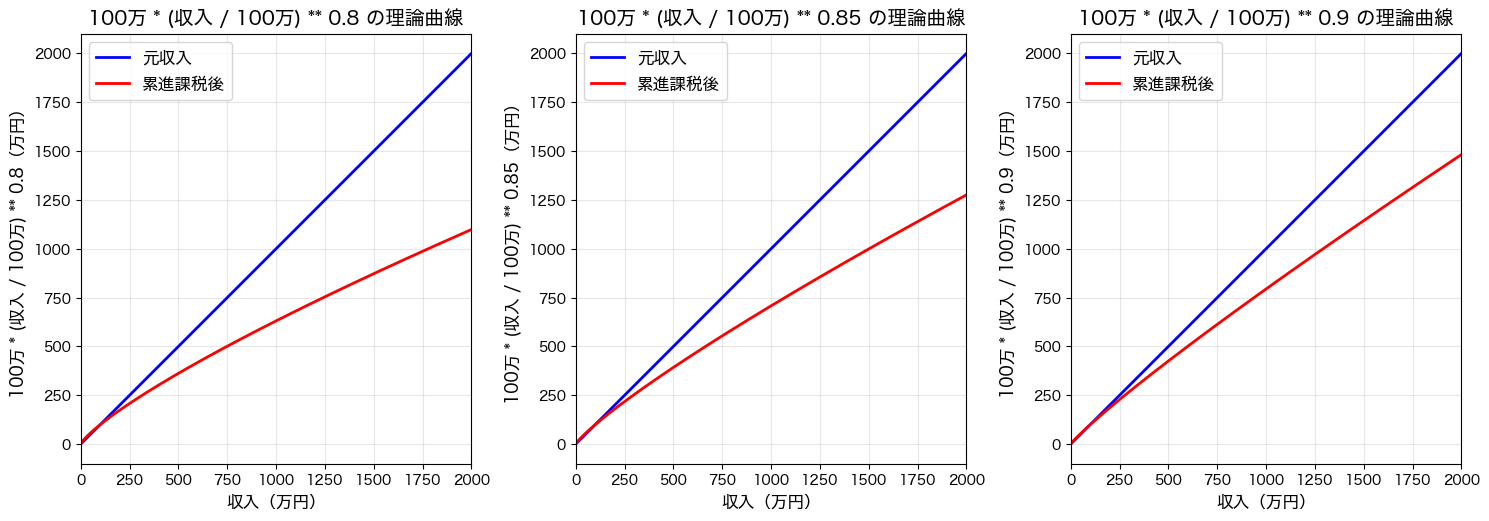

In [43]:
# 0~2000万円の範囲で連続的に 100万 * (値 / 100万) ** 0.8 を計算してプロット

# 0~2000万円の範囲で連続的な値を生成
x = np.linspace(0, 2000, 1000)  # 0から2000万円まで1000点

### 逓減率0.8の累進課税 ###
# 100万 * (値 / 100万) ** 0.8 を計算（万円単位）
# xが0の場合は0を返す
y = np.where(x > 0, 100 * ((x / 100) ** 0.8), 0)

# グラフを描画
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.plot(x, x, linewidth=2, color='blue', label='元収入')
plt.plot(x, y, linewidth=2, color='red', label="累進課税後")
plt.xlabel('収入（万円）', fontsize=12)
plt.ylabel('100万 * (収入 / 100万) ** 0.8（万円）', fontsize=12)
plt.title('100万 * (収入 / 100万) ** 0.8 の理論曲線', fontsize=14)
plt.xlim(0, 2000)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
# x, yのアスペクトを1:1にする
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

### 逓減率0.85の累進課税 ###
# 100万 * (値 / 100万) ** 0.85 を計算（万円単位）
# xが0の場合は0を返す
y085 = np.where(x > 0, 100 * ((x / 100) ** 0.85), 0)
# グラフを描画
plt.subplot(1, 3, 2)
plt.plot(x, x, linewidth=2, color='blue', label='元収入')
plt.plot(x, y085, linewidth=2, color='red', label="累進課税後")
plt.xlabel('収入（万円）', fontsize=12)
plt.ylabel('100万 * (収入 / 100万) ** 0.85（万円）', fontsize=12)
plt.title('100万 * (収入 / 100万) ** 0.85 の理論曲線', fontsize=14)
plt.xlim(0, 2000)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
# x, yのアスペクトを1:1にする
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

# 逓減率0.9の累進課税
# 100万 * (値 / 100万) ** 0.9 を計算（万円単位）
# xが0の場合は0を返す
y09 = np.where(x > 0, 100 * ((x / 100) ** 0.9), 0)
# グラフを描画
plt.subplot(1, 3, 3)
plt.plot(x, x, linewidth=2, color='blue', label='元収入')
plt.plot(x, y09, linewidth=2, color='red', label="累進課税後")
plt.xlabel('収入（万円）', fontsize=12)
plt.ylabel('100万 * (収入 / 100万) ** 0.9（万円）', fontsize=12)
plt.title('100万 * (収入 / 100万) ** 0.9 の理論曲線', fontsize=14)
plt.xlim(0, 2000)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
# x, yのアスペクトを1:1にする
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

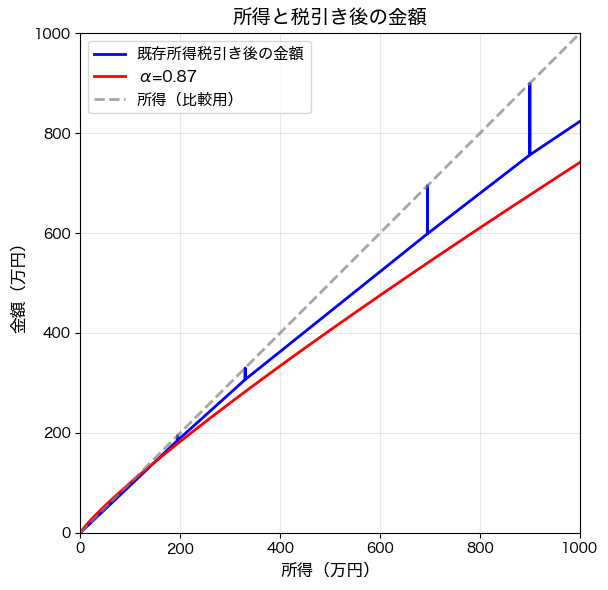

計算範囲: 0円 ~ 1億円
計算点数: 10000


In [60]:
# income_tax_listに基づいて所得税引き後の金額をグラフ化. 累進課税率のグラフ
income_tax_list = [
    {
        "income_range": (1000, 1_949_000),  
        "tax_rate": 0.05,
        "deduction": 0,
    },
    {
        "income_range": (1_950_000, 3_299_000),
        "tax_rate": 0.1,
        "deduction": 97_500,
    },
    {
        "income_range": (3_300_000, 6_949_000),
        "tax_rate": 0.2,
        "deduction": 427_500,
    },
    {   
        "income_range": (6_950_000, 8_999_000),
        "tax_rate": 0.23,
        "deduction": 636_000,
    },
    {
        "income_range": (9_000_000, 17_999_000),
        "tax_rate": 0.33,
        "deduction": 1_536_000,
    },
    {
        "income_range": (18_000_000, 39_999_000),
        "tax_rate": 0.4,
        "deduction": 2_796_000,
    },
    {
        "income_range": (40_000_000, float('inf')),
        "tax_rate": 0.45,
        "deduction": 4_796_000,
    },
]

# 横軸: 0円から1億円まで
x_max = 10_000_000
#income_range = np.linspace(0, 100_000_000, 10000)  # 1億円まで10000点
income_range = np.linspace(0, x_max, 10000)  # 1億円まで10000点

# 所得税引き後の金額を計算する関数
def calculate_after_tax_income(income):
    """所得から所得税を引いた金額を計算"""
    for tax_info in income_tax_list:
        min_income, max_income = tax_info['income_range']
        if min_income <= income <= max_income:
            tax = income * tax_info['tax_rate'] - tax_info['deduction']
            # 所得税が負の値にならないようにする
            tax = max(0, tax)
            return income - tax
    # 範囲外の場合は所得税なし
    return income

# 各所得に対する所得税引き後の金額を計算
after_tax_incomes = [calculate_after_tax_income(inc) for inc in income_range]

# グラフを描画
plt.figure(figsize=(9, 6))
plt.plot(income_range, after_tax_incomes, label='既存所得税引き後の金額', linewidth=2, color='blue')

# 逓減率0.9の累進課税
# 100万 * (値 / 100万) ** 0.9 を計算（万円単位）
# xが0の場合は0を返す
alpha = 0.87
y09 = np.where(income_range / 1_000_000 > 0, 
                1_000_000 * ((income_range / 1_000_000) ** alpha), 0)
plt.plot(income_range, y09, linewidth=2, color='red', label=f"α={alpha}")

plt.plot(income_range, income_range, label='所得（比較用）', linewidth=2, linestyle='--', color='gray', alpha=0.7)

# 横軸と縦軸を万円単位で表示


def format_manen(x, pos):
    """万円単位に変換して表示"""
    return f'{x/10000:.0f}'

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_manen))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_manen))
# x, yのアスペクトを1:1にする
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('所得（万円）', fontsize=12)
plt.ylabel('金額（万円）', fontsize=12)
plt.title('所得と税引き後の金額', fontsize=14)
plt.xlim(0, x_max)
plt.ylim(0, x_max)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"計算範囲: 0円 ~ 1億円")
print(f"計算点数: {len(income_range)}")


## prompt 世帯あたりの最低生活保障・余剰金額を算出
以下の手順で世帯あたりの最低生活保障・余剰金額を算出しjsonファイルに出力する関数を生成して
1. 入力はpersonsのjsonパス
2. personごとの`最低生活保障`, 各余剰金額(`calc_individual_surplus`の出力)を取得
3. personを`household_id`で世帯グループ化する
4. 世帯ごとに、最低生活保障・各余剰金額をそれぞれ合計する
5. 以下のdictを生成しjsonに保存
   ```
   `household_id`: {
      "household_info": {
         "最低生活保障総額": 最低生活保障合計,
         "α逓減後収入総額": `deduct_income_total`,
         "β世帯構成補正後収入総額": `beta_deduct_income_total`,
         "余剰金額総額": `surplus_total`,
      },
      "persons": [
         {
            "person_id": "person_id",
            "最低生活保障": 最低生活保障,
            "α逓減後収入": `deduct_income`,
            "β世帯構成補正後収入": `beta_deduct_income`,
            "余剰金額": `surplus`,
         },
         ...
      ]
   },
   ...
   ```

In [68]:
persons_bi_income_household_json = root / 'persons_BI_income_household.json'
with persons_bi_income_household_json.open('r', encoding='utf-8') as f:
    persons_bi_income_household = json.load(f)

# パラメータ定義（必要に応じて調整）
alpha_offset = 1_000_000  # 例: 100万円
alpha = 0.8  # 例: 0.5
gamma = 1.0  # 例: 1.0

# 世帯補正パラメータ beta（パターンごと）
beta_values = {
    "single_young": 1, 
    "single_elder": 0.75,  # 高齢で消費減   
    "couple_young": 0.75,  # 共用でコスト減
    "couple_elder": 0.5,  # 高齢, 共用で消費減
    "child": 0.5  # 子供, 共用で消費減
}

calculate_surplus(persons_bi_income_household, alpha_offset, alpha, gamma, beta_values)


[従来]手取り(所得税引き後収入+手当)合計: 311.30億円
最低生活保障合計: 100.79億円
余剰金額合計: 196.23億円
[新規]最低生活保障合計 + 余剰金額合計: 297.02億円

比較:
[従来]-[新規] 差額: 14.28億円


In [75]:
persons_bi_income_household_json = root / 'persons_BI_income_household.json'
with persons_bi_income_household_json.open('r', encoding='utf-8') as f:
    persons_bi_income_household = json.load(f)

# パラメータ定義（必要に応じて調整）
alpha_offset = 1_000_000  # 例: 100万円
alpha = 0.85  # 例: 0.5
gamma = 0.95  # 例: 1.0

# 世帯補正パラメータ beta（パターンごと）
beta_values = {
    "single_young": 1, 
    "single_elder": 0.75,  # 高齢で消費減   
    "couple_young": 0.75,  # 共用でコスト減
    "couple_elder": 0.6,  # 高齢, 共用で消費減
    "child": 0.6  # 子供, 共用で消費減
}

calculate_surplus(persons_bi_income_household, alpha_offset, alpha, gamma, beta_values)


[従来]手取り(所得税引き後収入+手当)合計: 311.30億円
最低生活保障合計: 100.79億円
余剰金額合計: 208.23億円
[新規]最低生活保障合計 + 余剰金額合計: 309.01億円

比較:
[従来]-[新規] 差額: 2.29億円


In [89]:
persons_bi_income_household_json = root / 'persons_BI_income_household.json'
with persons_bi_income_household_json.open('r', encoding='utf-8') as f:
    persons_bi_income_household = json.load(f)

# パラメータ定義（必要に応じて調整）
alpha_offset = 1_000_000  # 例: 100万円
alpha = 0.85  # 例: 0.5
gamma = 0.95  # 例: 1.0

# 世帯補正パラメータ beta（パターンごと）
beta_values = {
    "single_young": 1, 
    "single_elder": 0.75,  # 高齢で消費減   
    "couple_young": 0.8,  # 共用でコスト減
    "couple_elder": 0.55,  # 高齢, 共用で消費減
    "child": 0.5  # 子供, 共用で消費減
}

calculate_surplus(persons_bi_income_household, alpha_offset, alpha, gamma, beta_values)


[従来]手取り(所得税引き後収入+手当)合計: 311.30億円
最低生活保障合計: 100.79億円
余剰金額合計: 210.36億円
[新規]最低生活保障合計 + 余剰金額合計: 311.14億円

比較:
[従来]-[新規] 差額: 0.16億円


In [ ]:
# 個人単位に修正した世帯タイプに基づく計算
persons_bi_income_household_json = root / 'persons_BI_income_household2.json'
with persons_bi_income_household_json.open('r', encoding='utf-8') as f:
    persons_bi_income_household = json.load(f)

# パラメータ定義（必要に応じて調整）
alpha_offset = 1_000_000  # 例: 100万円
alpha = 0.85  # 例: 0.5
gamma = 0.95  # 例: 1.0

# 世帯補正パラメータ beta（パターンごと）
beta_values = {
    "single_young": 1, 
    "single_elder": 0.75,  # 高齢で消費減   
    "couple_young": 0.80,  # 共用でコスト減
    "couple_elder": 0.60,  # 高齢, 共用で消費減
    "child": 0.55  # 子供, 共用で消費減
}

calculate_surplus(persons_bi_income_household, 
                alpha_offset, alpha, gamma, beta_values)


[従来]手取り(所得税引き後収入+手当)合計: 311.30億円
最低生活保障合計: 100.79億円
余剰金額合計: 210.11億円
[新規]最低生活保障合計 + 余剰金額合計: 310.89億円

比較:
[従来]-[新規] 差額: 0.40億円


# prompt
`income_tax_list`の情報にもとづいて、下記手順によりグラフを描画してください。
1. 横軸を所得とし、縦軸を所得税引き後の金額とする
2. 横軸の範囲は0円から1億円までとする
3. 所得が`income_range`の範囲内にあるdictを参照し、`所得税 = 所得 * tax_rate - deduction`を計算する
4. `所得 - 所得税`をプロットする
5. 比較のベースのために、縦軸も所得となる線もプロットする



In [77]:
13.4/17

0.788235294117647

In [79]:
134257/154346

0.869844375623599

## prompt 世帯タイプごとの最低生活保障総額を計算
以下の手順で世帯タイプごとの最低生活保障総額を計算するコードを生成して
1. persons_bi_income_household.json を読み込む
2. `household_id`をもとに、世帯単位の最低生活保障総額を計算する
3. `世帯タイプ`ごとの、各世帯における最低生活保障総額の平均を計算する


In [ ]:
# 世帯タイプごとの最低生活保障総額を計算
from pathlib import Path
import json
from collections import defaultdict

root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero')
json_path = root / 'persons_BI_income_household.json'

# JSONを読み込み
with json_path.open('r', encoding='utf-8') as f:
    persons_bi_income_household = json.load(f)

# household_idごとに最低生活保障を集計
household_totals = {}  # {household_id: 最低生活保障総額}
household_types = {}  # {household_id: 世帯タイプ}

for person_id, person in persons_bi_income_household.items():
    household_id = str(person.get('household_id', ''))
    if not household_id:
        continue
    
    bi = float(person.get('最低生活保障', 0))
    household_type = person.get('世帯タイプ', '')
    
    # 世帯ごとの最低生活保障を合計
    if household_id not in household_totals:
        household_totals[household_id] = 0.0
        household_types[household_id] = household_type
    
    household_totals[household_id] += bi

# 世帯タイプごとに、各世帯の最低生活保障総額をグループ化
type_to_household_totals = defaultdict(list)
for household_id, total in household_totals.items():
    household_type = household_types.get(household_id, '')
    if household_type:
        type_to_household_totals[household_type].append(total)

# 世帯タイプごとの平均を計算
type_to_average = {}
for household_type, totals in type_to_household_totals.items():
    if totals:
        average = sum(totals) / len(totals)
        type_to_average[household_type] = average

# 結果を表示
print("世帯タイプごとの最低生活保障総額の平均:")
print("-" * 60)
for household_type in sorted(type_to_average.keys()):
    average = type_to_average[household_type]
    count = len(type_to_household_totals[household_type])
    print(f"{household_type}:")
    print(f"  世帯数: {count}")
    print(f"  平均最低生活保障総額: {average / 10000:.2f}万円 ({average / 100_000_000:.2f}億円)")
    print()

# 全体の統計も表示
total_households = len(household_totals)
total_bi = sum(household_totals.values())
print(f"全体:")
print(f"  総世帯数: {total_households}")
print(f"  最低生活保障総額合計: {total_bi / 10000:.2f}万円 ({total_bi / 100_000_000:.2f}億円)")
print(f"  世帯あたり平均: {total_bi / total_households / 10000:.2f}万円")


世帯タイプごとの最低生活保障総額の平均:
------------------------------------------------------------
child:
  世帯数: 726
  平均最低生活保障総額: 26.33万円 (0.00億円)

couple_elder:
  世帯数: 701
  平均最低生活保障総額: 18.14万円 (0.00億円)

couple_young:
  世帯数: 1439
  平均最低生活保障総額: 20.18万円 (0.00億円)

single_elder:
  世帯数: 844
  平均最低生活保障総額: 12.83万円 (0.00億円)

single_young:
  世帯数: 931
  平均最低生活保障総額: 13.20万円 (0.00億円)

全体:
  総世帯数: 4641
  最低生活保障総額合計: 83988.05万円 (8.40億円)
  世帯あたり平均: 18.10万円


# 代表的な世帯例での計算

In [124]:
root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero/data/example')
os.makedirs(root, exist_ok=True)
data_persons_path = root / 'data_persons_ex.csv'
data_households_path = root / 'data_households_ex.csv'
data_households_allowance_path = root / 'data_households_allowance_ex.csv'
data_persons_bi_path = root / 'persons_BI_ex.json'
output_json_path = root / 'result_household_ex.json'

# パラメータ定義（必要に応じて調整）
alpha_offset = 1_000_000  # 例: 100万円
alpha = 0.85  # 例: 0.5
gamma = 0.95  # 例: 1.0

# 世帯補正パラメータ beta（パターンごと）
beta_values = {
    "single_young": 1, 
    "single_elder": 0.75,  # 高齢で消費減   
    "couple_young": 0.80,  # 共用でコスト減
    "couple_elder": 0.60,  # 高齢, 共用で消費減
    "child": 0.55  # 子供, 共用で消費減
}

# OpenFisca-Japanで手当(生活保護・児童関連手当)を計算する
calc_all(data_persons_path,
            data_households_path,
            data_households_allowance_path,
            data_persons_bi_path,
            output_json_path,
            beta_values,
            alpha_offset,
            alpha,
            gamma)


Wrote: /Users/naoya/develop/proj-inclusive/OpenFisca-Zero/data/example/persons_BI_ex.json
Wrote: /Users/naoya/develop/proj-inclusive/OpenFisca-Zero/data/example/persons_BI_ex.json
出力完了: /Users/naoya/develop/proj-inclusive/OpenFisca-Zero/data/example/result_household_ex.json
世帯数: 2
